In [3]:
%matplotlib inline
import sys
sys.path.append('/home/paulo/git/bayeseg')

import time
import datetime

import numpy as np
import pandas as pd

from SeqSeg.SeqSeg import SeqSeg

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation

savefolder = '/home/paulo/github/bayeseg/Output/'

# Posteriori para $\bar{t}$ quando $\delta = 1$

In [2]:
ss = SeqSeg(replicate = False)

#Gera dados
N = 10000
y = np.random.normal(scale = 1.0, size = N)

ss.feed_data(y)

In [3]:
p, _ = ss.get_posterior(0, N, minlen = 1000)

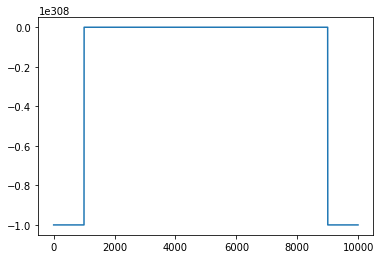

In [5]:
plt.plot(p)

## Testing the algorithm on real samples

In [2]:
from OceanPod import OceanPod 


wavfolder = '/home/paulo/github/bayeseg/Data/'
savefolder = '/home/paulo/github/bayeseg/Output/'
filelist = ['2015.01.30_02.02.56.wav', '2015.02.02_07.50.49.wav', '2015.02.08_11.26.39.wav']

# Creates object to read wave files and segments
op = OceanPod(wavfolder)

In [3]:
# MCMC parameters

mciter = 20000
mcburn = 20000
nchains = 1


In [51]:
ss = SeqSeg(replicate = False)

file = filelist[2]

fs, wave = op.readFile(file)
ss.feed_data(wave)

alpha = 0.5819
beta = 5e-3

ss.initialize(beta, alpha, mciter, mcburn, nchains)
tseg, tdur = ss.segments(minlen = 11025, res = 1000, iprior = 0, regularize = False, verbose = False)
print(len(tseg)+1, tdur)

175 3.163956880569458


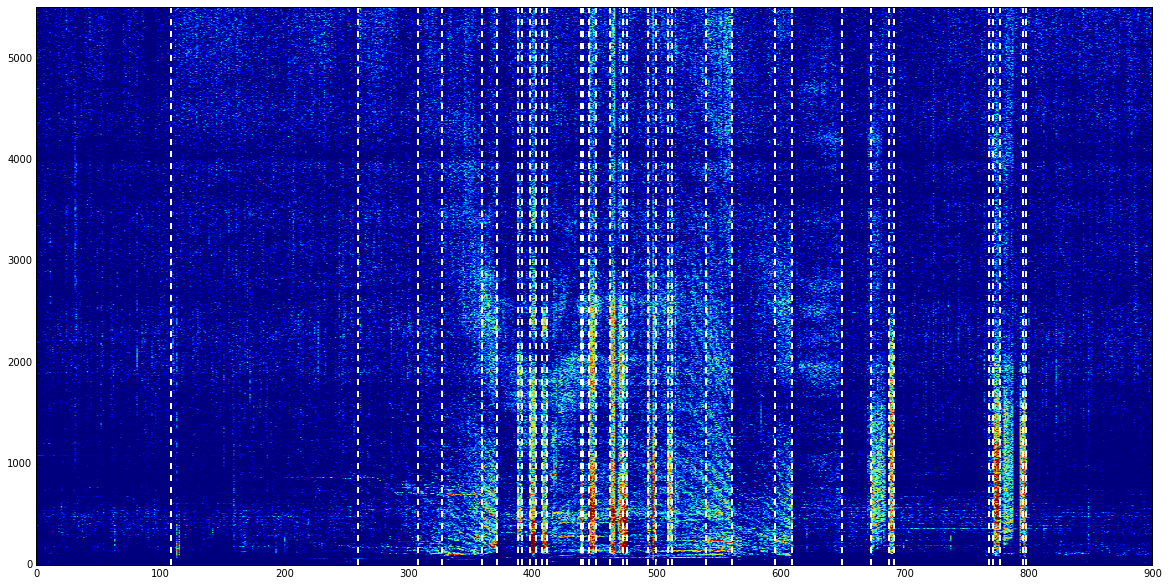

In [5]:
M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

lines = []
for s in tseg:
    lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))

In [6]:
tseg.sort()

tstart = 0
tend = tseg[1]
tcut = tseg[0]

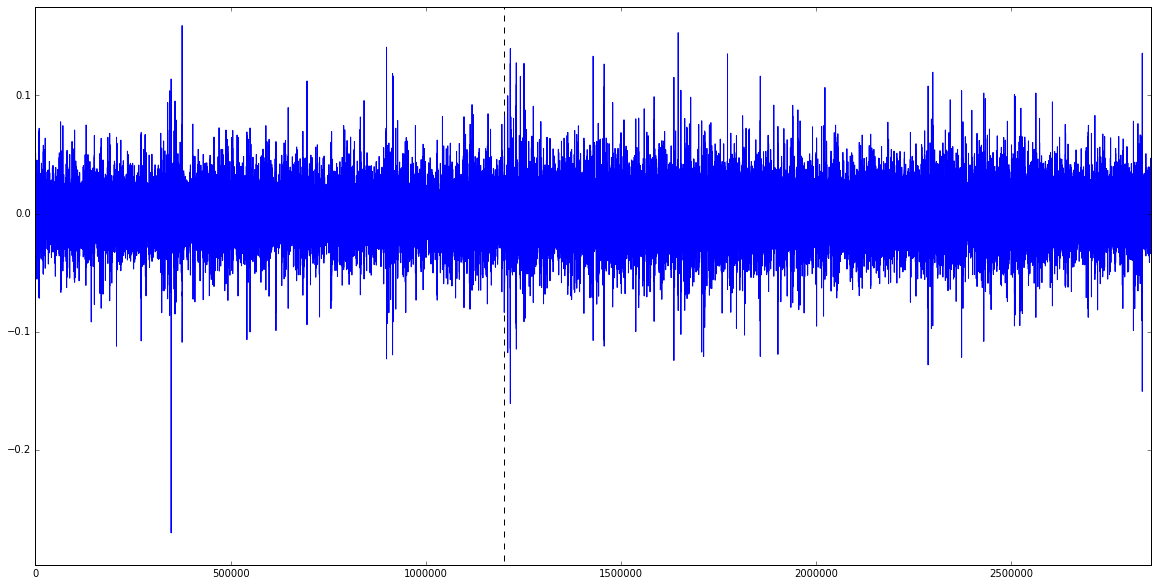

In [7]:
seg = wave[tstart:tend]
fig = plt.figure(figsize = (20, 10))
plt.plot(seg)
plt.vlines(x = tcut, ymin = np.min(seg)*1.2, ymax = np.max(seg)*1.2, linestyles = 'dashed')
plt.ylim([np.min(seg)*1.1, np.max(seg)*1.1])
plt.xlim([tstart, tend])
plt.show()


In [8]:
print((1/(np.var(seg[:tcut])/np.var(seg[tcut:]))))

1.3555026087816224


In [ ]:
import sounddevice as sd

seg = wave[tstart:tend]
plt.plot(seg, '-')
print((tend-tstart)/11025)

sd.play(seg, 11025)

In [ ]:
sd.stop()

In [9]:
ss.feed_data(wave[tstart:tend])
ss.tester(tcut = tcut, iprior = 1)

0.0

# Teste: elicitando a prior para delta

Conclusão: isso não funciona porque na prática o algoritmo não estará comparando segmentos homogêneos. Portanto, dizer que quero rejeitar segmentos de $t$ segundos com $\delta \le d$ não leva em conta que um dos segmentos pode conter um evento menor do que $t$ segundos, seguido por ruído de fundo, o que vai diminuir artificialmente a estimativa de $\delta$

In [54]:
fs = 11025
t = 1
n = t * fs
d = 1.1
y = np.concatenate([np.random.normal(loc = 0.0, scale = 1, size = (n,1)), np.random.normal(loc = 0.0, scale = d, size = (n,1))])
#plt.plot(y)
ss.feed_data(y)

alpha = 0.1
betalist = np.linspace(3e-6, 3e-2, 100)

evs = []
betamax = -1
for beta in betalist:
    ss.initialize(beta, alpha, mciter, mcburn, nchains)
    ev = ss.tester(tcut = n, iprior = 0)
    evs.append(ev)
    if ev == 1:
        if beta > betamax:
            betamax = beta
            

In [55]:
betamax

0.002124

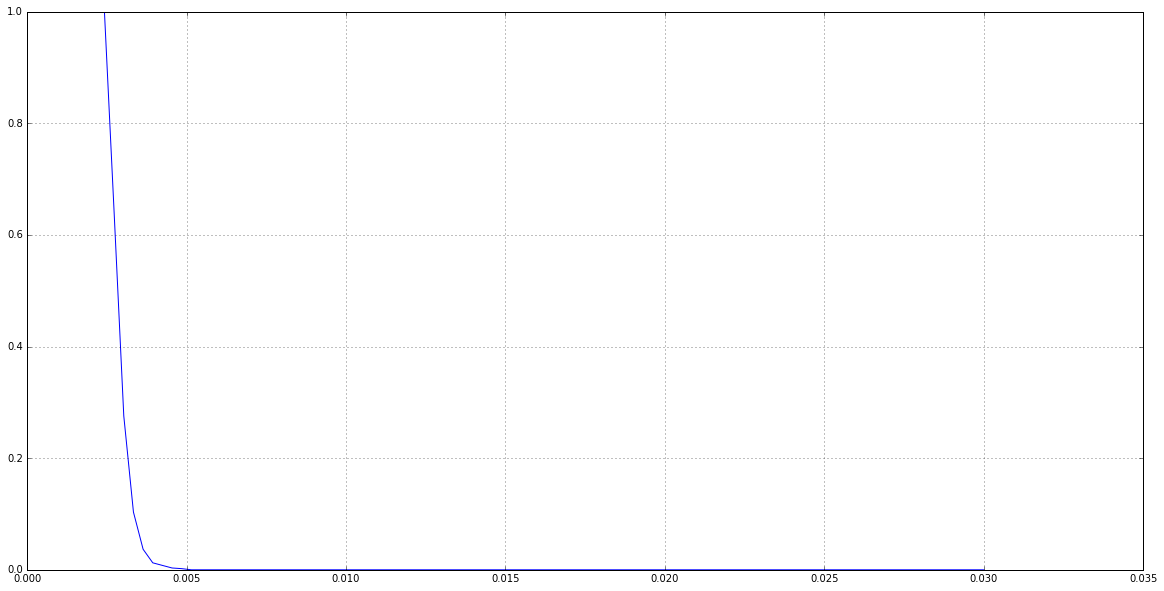

In [56]:
fig = plt.figure(figsize = (20, 10))
plt.plot(betalist, evs)
plt.grid(True)

# Teste 2: calculando uma medida de GOF

AIC e BIC

In [52]:
from tqdm import tqdm

bics = []
aics = []
for i in tqdm(range(1,len(tseg)+1)):
    tcuts = tseg[:i]
    tcuts.sort()
    loglik = 0
    for j in range(len(tcuts)):
        if j == 0:
            s = np.var(wave[:tcuts[j]])
            loglik = loglik - (tcuts[j]/2)*np.log(s) - np.sum(wave[:tcuts[j]]**2)/(2*s)
        elif j < len(tcuts)-1:
            s = np.var(wave[tcuts[j-1]:tcuts[j]])
            loglik = loglik - ((tcuts[j]-tcuts[j-1]+1)/2)*np.log(s) - np.sum(wave[tcuts[j-1]:tcuts[j]]**2)/(2*s)
        else:
            s = np.var(wave[tcuts[j]:])
            loglik = loglik - ((len(wave)-tcuts[j])/2)*np.log(s) - np.sum(wave[tcuts[j]:]**2)/(2*s)
    bic = np.log(len(wave))*(2*len(tcuts)+1) - 2*loglik
    aic = 2*(2*len(tcuts)+1) - 2*loglik
    bics.append(bic)
    aics.append(aic)
    

100%|██████████| 174/174 [00:10<00:00, 17.00it/s]


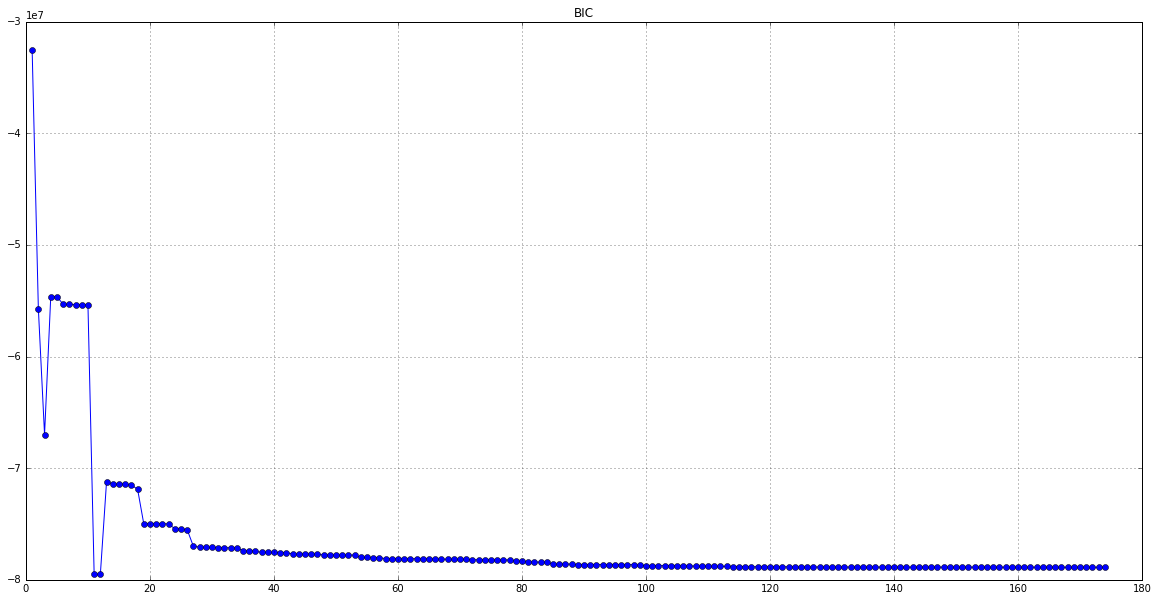

In [53]:
fig = plt.figure(figsize = (20, 10))
plt.plot(range(1, len(tseg) + 1), bics, 'o-')
plt.grid(True)
plt.title("BIC")
plt.show()

In [44]:
topt = tseg[:np.argmin(bics)-1]
topt = tseg[:38]

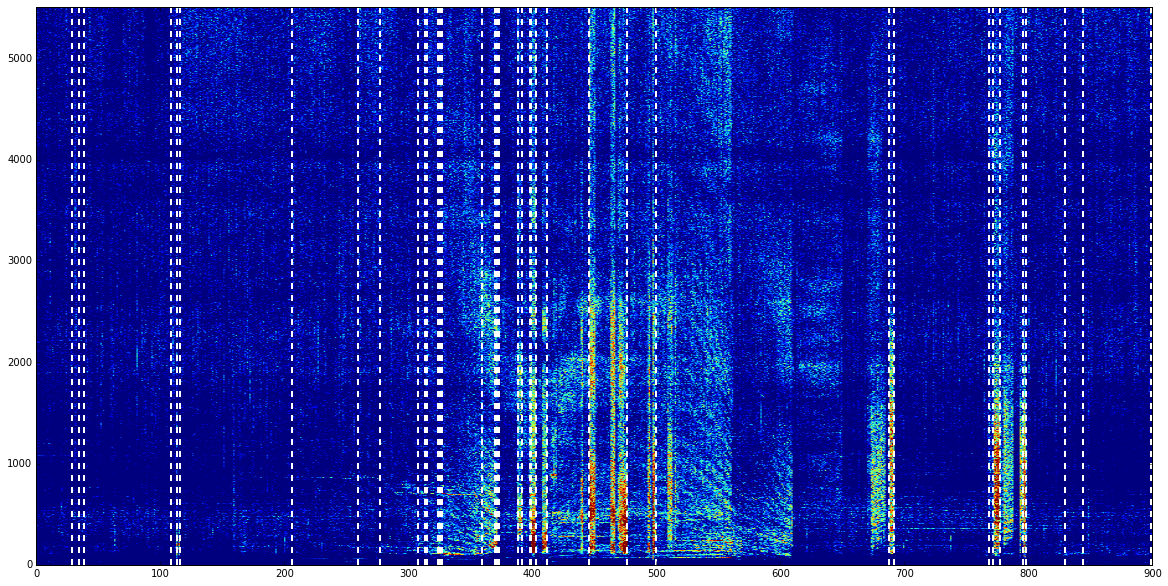

In [45]:
M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

lines = []
for s in topt:
    lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))

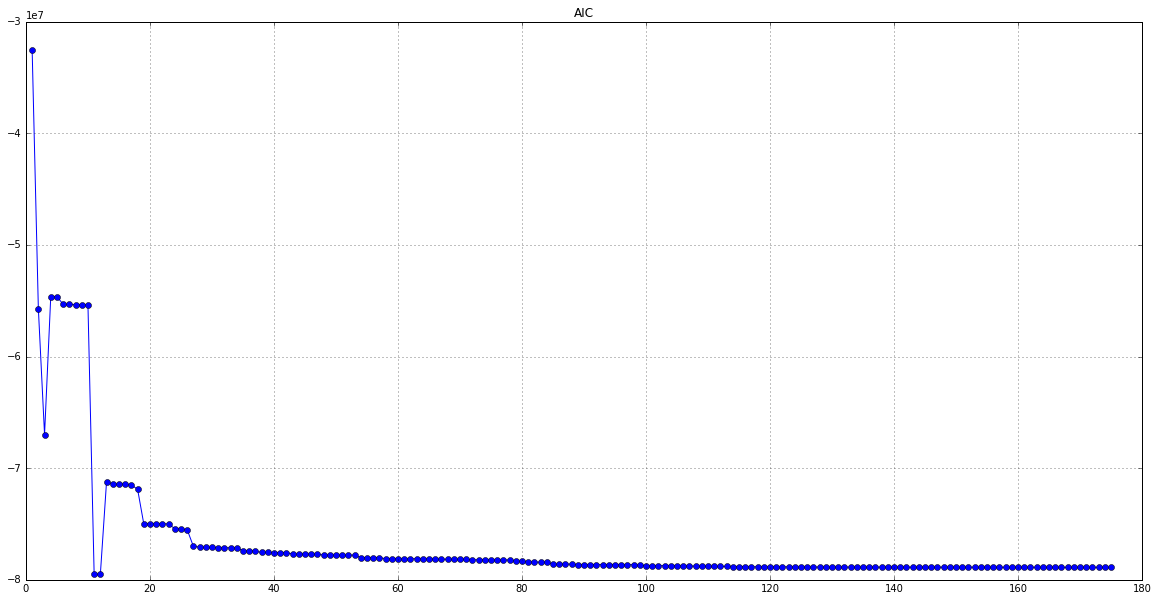

In [41]:
fig = plt.figure(figsize = (20, 10))
plt.plot(range(1, len(tseg) + 1), aics, 'o-')
plt.grid(True)
plt.title("AIC")
plt.show()

In [35]:
topt = tseg[:np.argmin(bics)-1]

# Comparando modelos

Com $n$ versus $n+1$ pontos de corte.

Em vez de testar a igualdade de variâncias, comparar os modelos usando o FBST.



# Posterior de t

In [5]:
# Obtaining the posterior on \bar{t}
file = filelist[2]

ss = SeqSeg(replicate = False)

fs, wave = op.readFile(file)
ss.feed_data(wave)

post, t = ss.get_posterior(0, len(wave))

wwidth = 11025
s = int(len(wave) / wwidth-1)
apost = np.zeros(shape = (s,))

for i in range(s):
    apost[i] = np.sum(post[i*wwidth:(i+1)*wwidth])

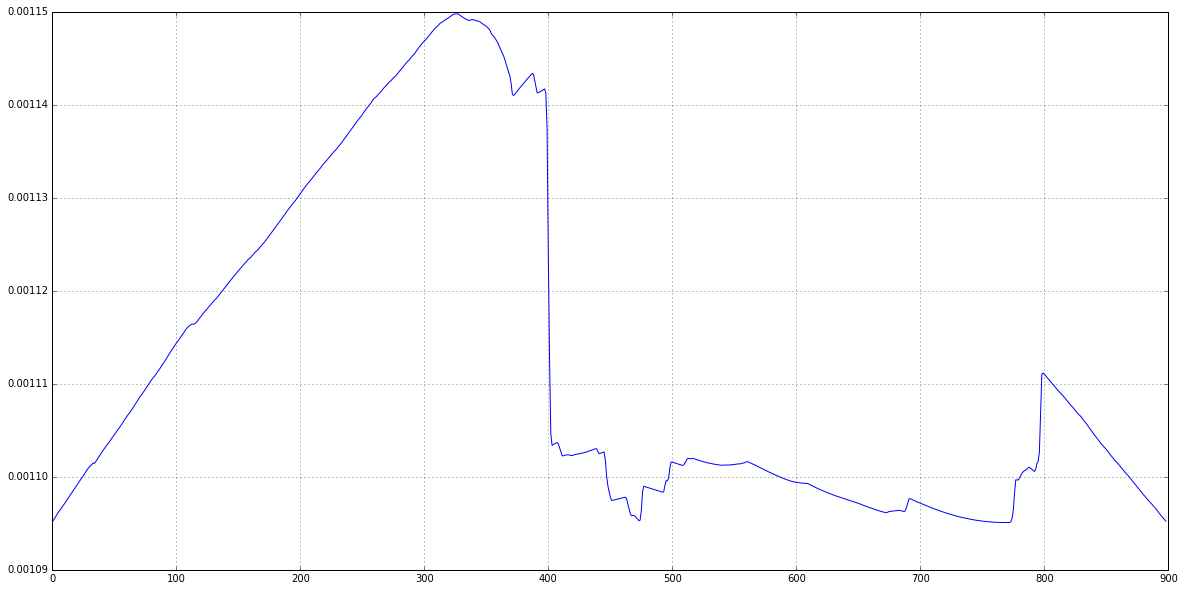

In [6]:
fig = plt.figure(figsize = (20, 10))
plt.plot(apost/np.sum(apost))
plt.grid(True)
#plt.savefig('/home/paulo/Documents/Apresentações/Post_08022015.png')
plt.show()

# Número de segmentos variando beta

In [ ]:
ss = SeqSeg(replicate = False)

file = filelist[2]

fs, wave = op.readFile(file)
ss.feed_data(wave)

alpha = 0.1
betalist = np.linspace(start = 5e-6, stop = 5e-5, num = 100)

results = []
for beta in betalist:
    ss.initialize(beta, alpha, mciter, mcburn, nchains)
    tseg, tdur = ss.segments(minlen = 11025, res = 11025, iprior = 0, verbose = False)
    nseg = len(tseg) + 1
    results.append((beta,tseg))
    print(beta, nseg)



# Criando gifs

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation

def update(i):
    tseg = results[i][1]
    if i > 0:
        tsegult = results[i-1][1]
    else:
        tsegult = []
    lines = []
    for s in tseg:
        if s not in tsegult:
            lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))
    msg = "Beta = {:.2}, N = {}".format(results[i][0], len(tseg) + 1)
    ax.set_xlabel(msg, fontsize = 22)
    return ax, lines

M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Frequency (Hz)', fontsize = 22)
plt.rcParams.update({'font.size' : 22})

# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, len(results)), interval=500)

anim.save('/home/paulo/Desktop/spec_lines_part1.gif', dpi=80, writer='imagemagick')

# plt.show() will just loop the animation forever.
plt.show()


# Criando espectrograma com prior de t 

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors

file = filelist[0]

ss = SeqSeg(replicate = False)

fs, wave = op.readFile(file)
ss.feed_data(wave)

post, t = ss.get_posterior(0, len(wave))

wwidth = 11025
s = int(len(wave) / wwidth-1)
apost = np.zeros(shape = (s,))

for i in range(s):
    apost[i] = np.sum(post[i*wwidth:(i+1)*wwidth])

fs, wave = op.readFile(file)

M = 11025
normalize = colors.Normalize(clip = False)

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.bwr, xextent=None, pad_to=None, sides='default',
         scale_by_freq=True, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

ax2 = ax.twinx()
ax2.plot(apost, color = 'black', linewidth = 2)

plt.savefig('/home/paulo/Documents/Apresentações/spec30012015.png')
plt.show()
#for s in tseg:
#    ax.axvline(x = s/fs, linestyle = '--', color = 'black')

In [ ]:
normalize = colors.Normalize(vmin = np.min(spec), vmax = np.max(spec), clip = False)
normalize(np.max(spec))